
***
# Programa para contagem de plantas de cafe
***
## Uso de CNN para identificação de plantas de cafe.   
A resolução inicial do treinamento foi de 300 x 300 pixels por planta de cafe, contudo, tem se probado satisfatorias fotos de 50x50 pixels.
As imagens originais foram compartilhas gentilmente pelo **Prof. Gabriel Ferraz**  o seu aluno **Gabriel Henrique**
***
Universidade Federal Fluminense / Departamento de eng. Agrícola e Meio ambiente / 
Author: Ivanovich Lache (*ilache@id.uff.br*)
***
## Instruções de uso
- Se quer testar a rede é só seguir as seções 0 e 2 do código
- Se quiser treinar o modelo, seguir as seções em sequencia (0,1,2)


# 0.  Carregamento da imagem

(4179, 8500, 4)


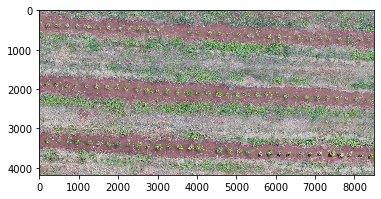

In [18]:
#%pylab inline

from PIL import Image
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.feature import match_template
import tensorflow as tf
import os

NomeArquivo='./imagens/MosaicoPouco.png'
#NomeArquivo='MetadeAreaTotal.png'

ImagenTotalOri=Image.open(NomeArquivo) #Grava a imagem original
ImagenTotal = np.asarray(ImagenTotalOri) #Converte a imagem em vetor
print(ImagenTotal.shape) #Identifica o tamanho da imagem
%matplotlib inline
plt.imshow(ImagenTotal) #Apresenta a imagem a ser analisada


TamanhoPixelFigura=50  

# 1. Treinamento da rede
Se a rede já foi treinada, pode ir direto para o item 2

## 1.1 Carregar pastas onde se encontram as amostras de plantas

In [6]:
import os
# Pasta para Treinamento onde se encontram as plantas de cafe
train_Cafe_dir = os.path.join('Mostras/Treino/Cafe')

# Pasta para treinamento onde se encontram as mostras que não são plantas de cafe
train_NCafe_dir = os.path.join('Mostras/Treino/NCafe')

# Pasta com as amostras de Validação para plantas de cafe
validation_Cafe_dir = os.path.join('Mostras/Valida/Cafe')

# Pasta para validação para amostas que não são plantas de cafe
validation_NCafe_dir = os.path.join('Mostras/Valida/NCafe')

### 1.1.1  Apresenta os primeirs 10 nomes dos arquivos das pastas
Este passo serve para verificar se os arquivos estão sendo lidos de forma adequada

In [71]:
train_Cafe_names = os.listdir(train_Cafe_dir)
print(train_Cafe_names[:10])

train_NCafe_names = os.listdir(train_NCafe_dir)
print(train_NCafe_names[:10])

validation_Cafe_hames = os.listdir(validation_Cafe_dir)
print(validation_Cafe_hames[:10])

validation_NCafe_names = os.listdir(validation_NCafe_dir)
print(validation_NCafe_names[:10])

['Cafe_01.png', 'Cafe_010.png', 'Cafe_011.png', 'Cafe_012.png', 'Cafe_013.png', 'Cafe_014.png', 'Cafe_015.png', 'Cafe_016.png', 'Cafe_017.png', 'Cafe_018.png']
['NoCafe_01.png', 'NoCafe_010.png', 'NoCafe_011.png', 'NoCafe_012.png', 'NoCafe_013.png', 'NoCafe_014.png', 'NoCafe_015.png', 'NoCafe_016.png', 'NoCafe_017.png', 'NoCafe_018.png']
['Cafe_053.png', 'Cafe_054.png', 'Cafe_055.png', 'Cafe_056.png', 'Cafe_057.png', 'Cafe_058.png', 'Cafe_059.png', 'Cafe_060.png', 'Cafe_061.png', 'Cafe_062.png']
['NoCafe_028.png', 'NoCafe_029.png', 'NoCafe_030.png', 'NoCafe_031.png', 'NoCafe_032.png', 'NoCafe_033.png', 'NoCafe_034.png', 'NoCafe_035.png', 'NoCafe_036.png', 'NoCafe_037.png']


In [72]:
# Identifica número de amostras para conjunto de treino e validação.
print('total training Cafe images:', len(os.listdir(train_Cafe_dir)))
print('total training NCafe images:', len(os.listdir(train_NCafe_dir)))
print('total validation Cafe images:', len(os.listdir(validation_Cafe_dir)))
print('total validation NCafe images:', len(os.listdir(validation_NCafe_dir)))

total training Cafe images: 75
total training NCafe images: 61
total validation Cafe images: 55
total validation NCafe images: 63


### 1.1.2 Apresenta visualmente as amostras de plantas de cafe e não plantas de cafe

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#Vão ser apresentadas 4x4 figuras
nrows = 4
ncols = 4
pic_index = 0  #Indice da figura

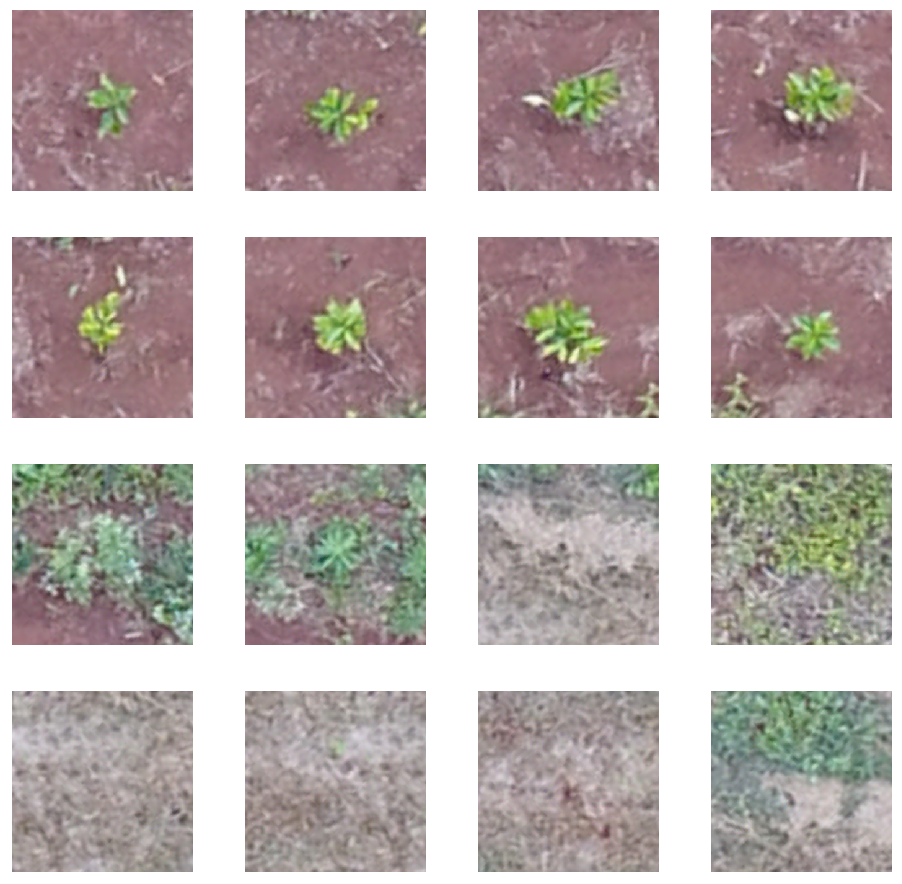

In [73]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4) #Define o tamanho da figura

pic_index += 8
next_Cafe_pix = [os.path.join(train_Cafe_dir, fname) 
                for fname in train_Cafe_names[pic_index-8:pic_index]]
next_NCafe_pix = [os.path.join(train_NCafe_dir, fname) 
                for fname in train_NCafe_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_Cafe_pix+next_NCafe_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Apaga os axis
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()


## 1.2 Criando a rede CNN



In [74]:
import tensorflow as tf

In [75]:
#Definir o tamanho da imagem que será apresntado para a Rede Neural, 
# neste caso são imagens de TamanhoPixelFigura * TamanhoPixelFigura

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image TamanhoPixelFiguraxTamanhoPixelFigura with 3 bytes color
    # Primeira Convolução
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(TamanhoPixelFigura, TamanhoPixelFigura, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Segunda convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Terceira convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Cria a rede que aprende utilizando as convoluçãos
    tf.keras.layers.Flatten(),
    # 300 Neuronios na camada oculta
    tf.keras.layers.Dense(300, activation='relu'),# Teste com 512 funcionou originalmente
    # Finalmente só um neoriono para definir duas clases, CAFE ou NãoCafe
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [76]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)             

In [77]:
#Definição de metricas e optimizador
from tensorflow.keras.optimizers import RMSprop
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

In [78]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Todas as imagens serão normalizadas.  Se utiliza uma aumentação de dados, utilizando o ratation_range, Horizontal_flip e Vertical_flip
train_datagen = ImageDataGenerator(rescale=1/255,
                                  rotation_range=45,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest'
                                  )
validation_datagen = ImageDataGenerator(rescale=1/255,
                                  rotation_range=45,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest'
                                  )

# Se dividem as imagens em batches de 15 utilizando o train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'Mostras/Treino',  # Aqui é a fonte das imagens de treino
        target_size=(TamanhoPixelFigura, TamanhoPixelFigura),  # TODAS as imagens são resized para O TamanoPixelFigura x TamanhoPixelFigura
        batch_size=15, #Tamanho del batch
        # Por utilizar binary_crossentropy loss, é necessario labels binarios
        class_mode='binary')

# Imagens de validação, dividas en batches de 12
validation_generator = validation_datagen.flow_from_directory(
        'Mostras/Valida',  # Pasta de validação
        target_size=(TamanhoPixelFigura, TamanhoPixelFigura),  
        batch_size=12,
        class_mode='binary')

Found 136 images belonging to 2 classes.
Found 118 images belonging to 2 classes.


In [79]:
history = model.fit(
      train_generator,
      steps_per_epoch=6,  
      epochs=18,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=6)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 6 steps, validate for 6 steps
Epoch 1/18
6/6 [==============================] - 31s 5s/step - loss: 0.9804 - accuracy: 0.5000 - val_loss: 0.6966 - val_accuracy: 0.4722
Epoch 2/18
6/6 [==============================] - 2s 284ms/step - loss: 0.7017 - accuracy: 0.6000 - val_loss: 0.6910 - val_accuracy: 0.4722
Epoch 3/18
6/6 [==============================] - 2s 288ms/step - loss: 0.7103 - accuracy: 0.5526 - val_loss: 0.7029 - val_accuracy: 0.4722
Epoch 4/18
6/6 [==============================] - 1s 235ms/step - loss: 0.6970 - accuracy: 0.6842 - val_loss: 0.6142 - val_accuracy: 1.0000
Epoch 5/18
6/6 [==============================] - 1s 243ms/step - loss: 0.6545 - accuracy: 0.7667 - val_loss: 0.5736 - val_accuracy: 0.5278
Epoch 6/18
6/6 [==============================] - 1s 214ms/step - loss: 0.7028 - accuracy: 0.6889 - val_loss: 0.4511 - val_accuracy: 1.0000
Epoch 7/18
6/6 [==============================] - 1s 206ms/step - loss: 

## 1.3 Resultados gráficos do treinamento


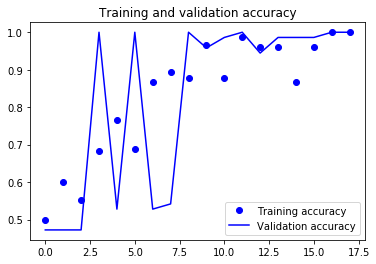

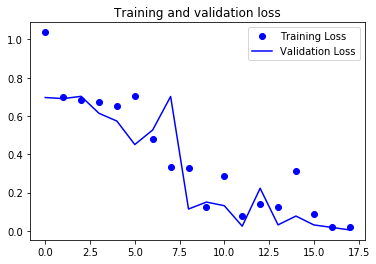

In [80]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 1.4 Salvar modelo


In [17]:
from tensorflow.keras.models import Sequential, save_model
from keras.models import load_model
model.save('./CNNModels/ModeloTopCAfe3.h5')  

***
# 2 Teste da rede neural 
***
## 2.1 Carregar modelo de rede

In [19]:
from tensorflow.keras.models import Sequential, save_model
from keras.models import load_model
model3=tf.keras.models.load_model('./CNNModels/ModeloTopCAfe2.h5')
model3.summary()
model=model3

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)             

## 2.2 Testes com figuras guardadas - Pequeno trecho

In [20]:

import numpy as np

from keras.preprocessing import image
import time
start_time = time.time()

for contador in range (0,119,1):    
    Nome='./PequenoTeste/'+'Total_00'+str(contador)+'.png'
    Endereco = os.path.join(Nome)
    img = image.load_img(Endereco, target_size=(TamanhoPixelFigura, TamanhoPixelFigura))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    
    if classes[0]>0.5:
        print("N_Cafe")
    else:
        print(" Es una planta de Cafe = ",str(contador))
print("Fim do Teste")
print("--- %s Segundos para a realização do teste ---" % (time.time() - start_time))

[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[0.]
 Es una planta de Cafe =  13
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[0.]
 Es una planta de Cafe =  43
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[0.]
 Es una planta de Cafe =  53
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[1.]
N_Cafe
[0.]
 Es una planta de Cafe =  73
[1.]
N_Cafe
[1.]
N_Cafe


## 2.3 Verificar a imagem que vai ser trabalhada



(4179, 8500, 4)


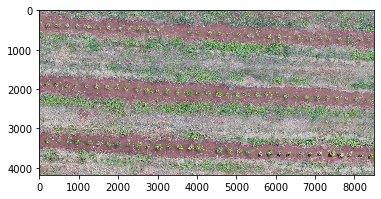

In [15]:
from PIL import Image
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.feature import match_template

#ImagenTotal = np.asarray(Image.open('MosaicoPouco.png'))  #Nome da imagem onde estão os templates
ImagenTotalOri=Image.open(NomeArquivo)
ImagenTotal = np.asarray(ImagenTotalOri)  #Nome da imagem onde estão os templates
print(ImagenTotal.shape)

plt.imshow(ImagenTotal)

## 2.4 Gera o código que fragmenta a imagem anterior e a testa contra a  CNN

In [103]:
import time
from keras.preprocessing import image
start_time = time.time()
    
Lado=150  #As figuras originais são de 300 pixel, por isso o lado da figura é de 150
contador=0

Paso=75 # Como quer ser procurada a figura, não pode ser maior que a variavel lado, conservadoramente se utilizó Lado/2
TetoX=np.round(np.shape(ImagenTotal)[1]/Lado)
TetoX=int((TetoX-1)*Lado)#Verifica o tamanho maximo em X
TetoY=np.round(np.shape(ImagenTotal)[0]/Lado)
TetoY=int((TetoY-1)*Lado)

xxx=range(150,TetoX,Paso)
yyy=range(150,TetoY,Paso)

val=int(((TetoX/Paso)-2)*((TetoY/Paso)-2))

historico=np.zeros(val)
indice=0

xhist=np.zeros(TetoX)
yhist=np.zeros(TetoY)
print("Inicio da procura de cafe na foto..")
for xis in range(150,TetoX,Paso): #Começa no eixo x
    for y in range(150,TetoY,Paso): # Começa no eixo Y
        
        ImagSub=ImagenTotalOri.crop((xis-Lado, y-Lado, xis+Lado, y+Lado)) #Pega so uma pequena parte imagem
        img = ImagSub.resize((TamanhoPixelFigura,TamanhoPixelFigura)) #Dimensiona essa imagem para o tamanho aceitavel pela 
        img_array = np.asarray(img) #Converte a imagem em vetor
        img_array=img_array[:,:,0:3] #Pega as informações de RGB
        x = np.expand_dims(img_array, axis=0) #As expande num eixo
        images = np.vstack([x]) #Empilha as infomrações

        classes = model.predict(images, batch_size=1) #Utiliza a rede para predizer
        #print(y)    
        if classes[0]<0.5:
            print("Cafe")
            historico[indice]=1
            xhist[contador]=xis
            yhist[contador]=y
            contador=contador+1 
            print(contador)
        else:
            historico[indice]=0
        indice=indice+1                
print("--- %s Segundos para o teste ---" % (time.time() - start_time))

5720
Inicio da procura de cafe na foto..
Cafe
1
Cafe
2
Cafe
3
Cafe
4
Cafe
5
Cafe
6
Cafe
7
Cafe
8
Cafe
9
Cafe
10
Cafe
11
Cafe
12
Cafe
13
Cafe
14
Cafe
15
Cafe
16
Cafe
17
Cafe
18
Cafe
19
Cafe
20
Cafe
21
Cafe
22
Cafe
23
Cafe
24
Cafe
25
Cafe
26
Cafe
27
Cafe
28
Cafe
29
Cafe
30
Cafe
31
Cafe
32
Cafe
33
Cafe
34
Cafe
35
Cafe
36
Cafe
37
Cafe
38
Cafe
39
Cafe
40
Cafe
41
Cafe
42
Cafe
43
Cafe
44
Cafe
45
Cafe
46
Cafe
47
Cafe
48
Cafe
49
Cafe
50
Cafe
51
Cafe
52
Cafe
53
Cafe
54
Cafe
55
Cafe
56
Cafe
57
Cafe
58
Cafe
59
Cafe
60
Cafe
61
Cafe
62
Cafe
63
Cafe
64
Cafe
65
Cafe
66
Cafe
67
Cafe
68
Cafe
69
Cafe
70
Cafe
71
Cafe
72
Cafe
73
Cafe
74
Cafe
75
Cafe
76
Cafe
77
Cafe
78
Cafe
79
Cafe
80
Cafe
81
Cafe
82
Cafe
83
Cafe
84
Cafe
85
Cafe
86
Cafe
87
Cafe
88
Cafe
89
Cafe
90
Cafe
91
Cafe
92
Cafe
93
Cafe
94
Cafe
95
Cafe
96
Cafe
97
Cafe
98
Cafe
99
Cafe
100
Cafe
101
Cafe
102
Cafe
103
Cafe
104
Cafe
105
Cafe
106
Cafe
107
Cafe
108
Cafe
109
Cafe
110
Cafe
111
Cafe
112
Cafe
113
Cafe
114
Cafe
115
Cafe
116
Cafe
117
Cafe
118
Cafe


## 2.4.* Alternativa para otimizar o tempo de analise

In [107]:
import time
from keras.preprocessing import image
start_time = time.time()
    
Lado=150  #Lado / 2 do quadrado onde se gera o template        
contador=0
#TetoX=150*56
#TetoY=150*27
Paso=75
TetoX=np.round(np.shape(ImagenTotal)[1]/Lado)
TetoX=int((TetoX-1)*Lado)
print(TetoX)
TetoY=np.round(np.shape(ImagenTotal)[0]/Lado)
TetoY=int((TetoY-1)*Lado)
print(TetoY)

xxx=range(150,TetoX,Paso)
yyy=range(150,TetoY,Paso)
print(np.size(xxx)*np.size(yyy))

val=int(((TetoX/Paso)-2)*((TetoY/Paso)-2))
print(val)
historico=np.zeros(val)
indice=0

xhist=np.zeros(TetoX)
yhist=np.zeros(TetoY)
print("Inicio da procura de cafe na foto..")

#**************AJUDA DO CV2***************************

import cv2
from matplotlib.colors import hsv_to_rgb
nemo = cv2.imread(NomeArquivo)
nemo = cv2.cvtColor(nemo, cv2.COLOR_BGR2RGB)
hsv_nemo = cv2.cvtColor(nemo, cv2.COLOR_RGB2HSV)


Terra= (177,80,170)
Terra2=(171,50,134)

lo_square = np.full((10, 10, 3), Terra, dtype=np.uint8) / 255.0
ho_square = np.full((10, 10, 3), Terra2, dtype=np.uint8) / 255.0
lo_square = np.full((10, 10, 3), Terra, dtype=np.uint8) / 255.0
ho_square = np.full((10, 10, 3), Terra2, dtype=np.uint8) / 255.0
mask = cv2.inRange(hsv_nemo, Terra2, Terra)
result = cv2.bitwise_and(nemo, nemo, mask=mask)
result1 = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
Filtro=np.asarray(result1)

#**** FIM DE FILTRO COM OPENCV ************
print(Filtro.shape)

for xis in range(150,TetoX,Paso): #56 é todo
    #print ('**x=',str(xis))
    
    for y in range(150,TetoY,Paso): # 27 é todo
#         #print ('y=',str(y))
#         imgcortada=ImagenTotal[xis-Lado:xis+Lado,y-Lado:y+Lado,0:3]
#         x = image.img_to_array(imgcortada)
#         x = np.expand_dims(x, axis=0)
#         images = np.vstack([x])

        TemTerra=np.mean(Filtro[ y-Lado:y+Lado,xis-Lado:xis+Lado]) #Filtro que detecta areas proximas de plantas de cafe (Terra)
        if TemTerra>0.4:
            ImagSub=ImagenTotalOri.crop((xis-Lado, y-Lado, xis+Lado, y+Lado))
            img = ImagSub.resize((TamanhoPixelFigura,TamanhoPixelFigura))#, Image.ANTIALIAS)
            img_array = np.asarray(img)
            img_array=img_array[:,:,0:3]
            x = np.expand_dims(img_array, axis=0)
            images = np.vstack([x])

            classes = model.predict(images, batch_size=1)
            #print(y)    
            if classes[0]<0.5:
                print("Cafe")
            
                historico[indice]=1
                xhist[contador]=xis
                yhist[contador]=y
                contador=contador+1 
                print(contador)
                #print('x=',str(xis),'y=',str(y))
            else:
                historico[indice]=0
            indice=indice+1                
print("--- %s seconds ---" % (time.time() - start_time))

8400
4050
5720
5720
Inicio da procura de cafe na foto..
(4179, 8500)
Cafe
1
Cafe
2
Cafe
3
Cafe
4
Cafe
5
Cafe
6
Cafe
7
Cafe
8
Cafe
9
Cafe
10
Cafe
11
Cafe
12
Cafe
13
Cafe
14
Cafe
15
Cafe
16
Cafe
17
Cafe
18
Cafe
19
Cafe
20
Cafe
21
Cafe
22
Cafe
23
Cafe
24
Cafe
25
Cafe
26
Cafe
27
Cafe
28
Cafe
29
Cafe
30
Cafe
31
Cafe
32
Cafe
33
Cafe
34
Cafe
35
Cafe
36
Cafe
37
Cafe
38
Cafe
39
Cafe
40
Cafe
41
Cafe
42
Cafe
43
Cafe
44
Cafe
45
Cafe
46
Cafe
47
Cafe
48
Cafe
49
Cafe
50
Cafe
51
Cafe
52
Cafe
53
Cafe
54
Cafe
55
Cafe
56
Cafe
57
Cafe
58
Cafe
59
Cafe
60
Cafe
61
Cafe
62
Cafe
63
Cafe
64
Cafe
65
Cafe
66
Cafe
67
Cafe
68
Cafe
69
Cafe
70
Cafe
71
Cafe
72
Cafe
73
Cafe
74
Cafe
75
Cafe
76
Cafe
77
Cafe
78
Cafe
79
Cafe
80
Cafe
81
Cafe
82
Cafe
83
Cafe
84
Cafe
85
Cafe
86
Cafe
87
Cafe
88
Cafe
89
Cafe
90
Cafe
91
Cafe
92
Cafe
93
Cafe
94
Cafe
95
Cafe
96
Cafe
97
Cafe
98
Cafe
99
Cafe
100
Cafe
101
Cafe
102
Cafe
103
Cafe
104
Cafe
105
Cafe
106
Cafe
107
Cafe
108
Cafe
109
Cafe
110
Cafe
111
Cafe
112
Cafe
113
Cafe
114
Cafe
115
Cafe

## 2.5 Identificar detecções que estão muito proximas

Estas detecções que estão muito proximas podem indicar sobre a localização de uma única planta. Assim, este código identifica quem esta proximo e modifica as coordenadas, deixando uma única coordenada (media) de todas os proximos

In [108]:
indicesx=np.where(xhist != 0)
indicesy=np.where(yhist != 0)

xhist = xhist[indicesx]  
yhist = yhist[indicesy]

limite=150
xhist2=np.copy(xhist)
yhist2=np.copy(yhist)
teto=10

for contador in range(0,np.size(yhist),1):
    valor=xhist2[contador]
    resul1=xhist2-valor
    indices=np.where(abs(resul1)<limite) #Verfica quais outras deteções tem aproximadamente a mesma coordena X
    valores=yhist2[indices[0]] #Puxa os valroes das coordenas Y  das pocições x pareceidas
    resul2=valores-yhist2[contador] 
    indices2=np.where(abs(resul2)<limite) #Verifica se tem posições Y proximas 
    xhist2[indices[0][indices2[0]]]=np.mean(xhist2[indices[0][indices2[0]]])  #Calcula a media das posições X que estão proximas
    yhist2[indices[0][indices2[0]]]=np.mean(yhist2[indices[0][indices2[0]]])  #Calcula a media das posições Y que estão proximas
#     if contador==0:   #Teste
#         print(xhist2[0:teto])
#         print(yhist2[0:teto])
#         print('***')


## 2.6 Elimina elementos iguais nos resultados

In [109]:

def EliminarParesIguais (x,y):
    parcial=x
    condi=0
    indice=0
    indice2=0
    avaliado=np.zeros(len(x))
    eliminar=np.zeros(len(y))
    for indice in range(len(x)):
        if eliminar[indice]==0:
            if indice<len(x)-1:
                for indice2 in range(indice+1,len(x),1):
                    if x[indice2]==x[indice]:
                        if y[indice2]==y[indice]:
                            eliminar[indice2]=1                                          
    Manter=np.where(eliminar!=1)
    return Manter
Manter=EliminarParesIguais(xhist2,yhist2)
IndicesManter=Manter[0]



## 2.7 Apresenta os resultados

In [110]:
%matplotlib qt

plt.figure(4)
plt.imshow(ImagenTotal)
xhist3=xhist2[IndicesManter]
yhist3=yhist2[IndicesManter]
plt.plot(xhist3,yhist3,'r*', markersize=20)
plt.plot(xhist,yhist,'b*', markersize=10)
for indices in range(len(xhist3)):
    plt.text(xhist3[indices],yhist3[indices],str(indices),fontsize='16')

print('Plantas de cafe encontradas=',str(len(xhist3)))



Plantas de cafe encontradas= 95


In [62]:
# Salva a figura gerada
plt.savefig('TesteCafe2.png')